# Plot Mars craters catalog on top of CTX image

In this notebook we will plot a catalog of Mars craters on top of Mars CTX image(s).

The CTX image I'm going to use:
- `P01_001388_2034_XI_23N017W.tif`, from ADAM (https://explorer-space.adamplatform.eu)

The Mars craters database (https://zenodo.org/record/3633594) provides central location and the radius for more than 300k craters all over the planet. We are going to use the "filtered" GeoJSON file provided by the database

In [54]:
# Data

mars_craters_file = 'data/Lagain_GSA_database/Global/lagain_db_filtered.json/lagain_db_filtered.json'

ctx_image_file = 'data/reduced/ctx/P01_001388_2034_XI_23N017W.tif'

## Mars craters database

- Lagain et al., 2017: https://zenodo.org/record/3633594

In [55]:
import geopandas

craters = geopandas.read_file(mars_craters_file, driver='GeoJSON')
craters

,CRATER_ID,RADIUS,X,Y,TYPE,STATUS,LRD_MORPH,ORIGIN,ADDING,geometry
0,200-007,500.0,23.671499,-43.584301,1.0,Other,None,None,1.0,POINT (23.67150 -43.58430)
1,200-008,500.0,68.432404,-39.950500,1.0,Other,None,None,1.0,POINT (68.43240 -39.95050)
2,200-009,500.0,177.154007,-0.758709,1.0,Other,None,None,1.0,POINT (177.15401 -0.75871)
3,200-010,500.0,34.128899,-31.406401,1.0,Other,None,None,1.0,POINT (34.12890 -31.40640)
4,100-001,500.0,-52.963100,47.302601,1.0,Other,None,None,1.0,POINT (-52.96310 47.30260)
...,...,...,...,...,...,...,...,...,...,...
376432,13-000940,4895.0,70.753998,22.677999,4.0,Secondary,None,None,0.0,POINT (70.75400 22.67800)
376433,13-000871,5210.0,61.212002,16.076000,4.0,Secondary,None,None,0.0,POINT (61.21200 16.07600)
376434,13-000729,6055.0,61.089001,15.822000,4.0,Secondary,None,None,0.0,POINT (61.08900 15.82200)
376435,13-000726,6075.0,61.083000,15.975000,4.0,Secondary,None,None,0.0,POINT (61.08300 15.97500)


In [56]:
# Coordinates Reference System

craters.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

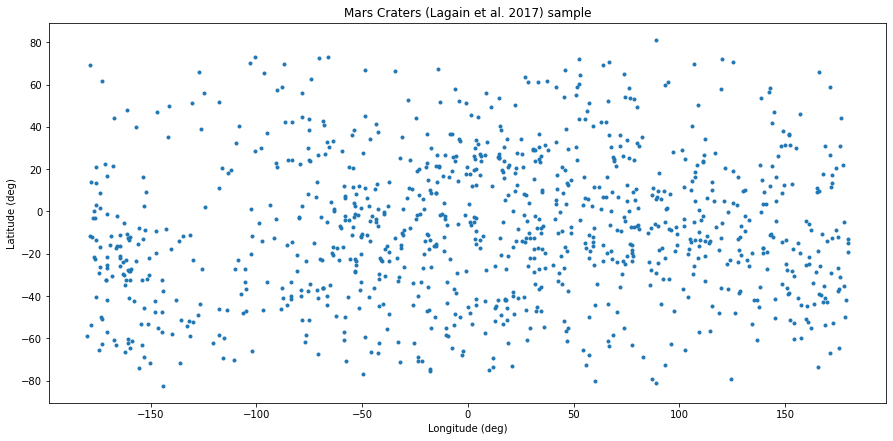

In [76]:
# General/sample view

ax = craters.sample(1000).plot(marker='.', figsize=(15,10))
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_title('Mars Craters (Lagain et al. 2017) sample');

**Note:**

Craters location are in degrees. GeoJSON files provide geometries/coordinates in _degrees_; By definition, the coordinates in there are considered to be in WGS84 (CRS), covering positions from -180:180 (longitude), -90:90 (latitude).

## MRO/CTX image

In [77]:
import rasterio

ctx_src = rasterio.open(ctx_image)
ctx_src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028226550889045e+38,
 'width': 546,
 'height': 759,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["sinusoidal Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",343],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(60.065934065934066, 0.0, -43560.0,
        0.0, -60.0, 1401990.0)}

/opt/miniconda3/envs/npt/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


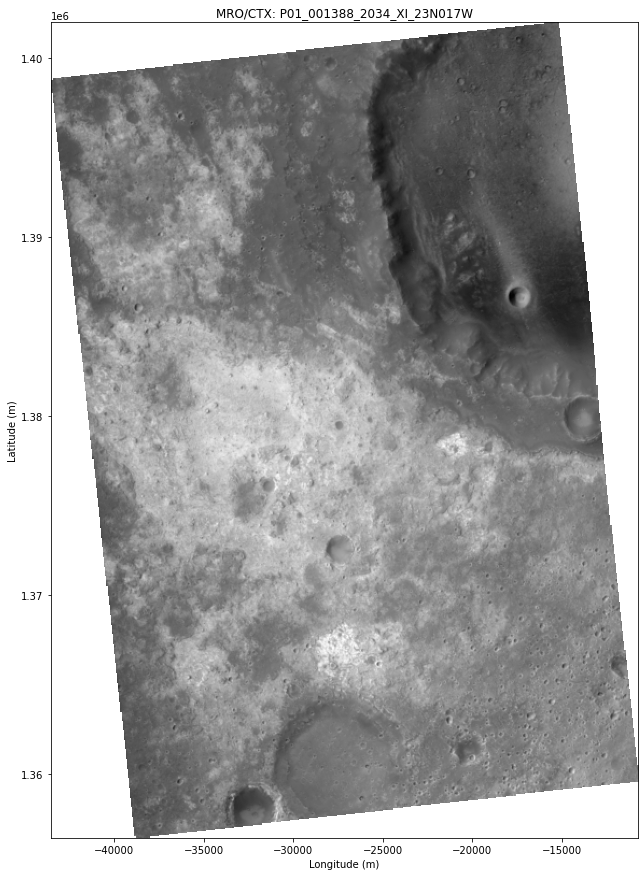

In [80]:
from rasterio import plot as rplot
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(15,15))

ax = rplot.show(ctx_src, ax=ax, cmap='gray')
ax.set_xlabel('Longitude (m)')
ax.set_ylabel('Latitude (m)')
ax.set_title('MRO/CTX: P01_001388_2034_XI_23N017W');

**Note:**

CTX image products as provided by ADAM Space-Explorer platform are projected in a (sinusoidal) projection representing coordinates in meters. When we combine both datasets (next), we should bring each and both to the same projection.

## Reproject Craters (deg) to Raster's CRS (meters)

The craters coordinates are _assumed_ (here, by Geopandas) to be in WGS84 because that how GeoJSON is defined (https://datatracker.ietf.org/doc/html/rfc7946). Sure enough, the coordinates of our Mars craters are _not_ in WGS84 but in Mars polar coordinates, also centered in 0, east-positive (-180:180).

What we have to do is to associate the equivalent coordinates system to Mars. The simplest reference system, defining de ellipsoid and coordinates limits and units is IAU-2000's (Mars) 49900 (https://spatialreference.org/ref/iau2000/49900/):
```
GEOGCS["Mars 2000",
    DATUM["D_Mars_2000",
        SPHEROID["Mars_2000_IAU_IAG",3396190.0,169.89444722361179]],
    PRIMEM["Greenwich",0],
    UNIT["Decimal_Degree",0.0174532925199433]]
```

In [86]:
iau2000_mars_wkt = """
GEOGCS["Mars 2000",
    DATUM["D_Mars_2000",
        SPHEROID["Mars_2000_IAU_IAG",3396190.0,169.89444722361179]],
    PRIMEM["Greenwich",0],
    UNIT["Decimal_Degree",0.0174532925199433]
]"""

#iau2000_mars_wkt = 'GEOGCS["Mars 2000",DATUM["D_Mars_2000",SPHEROID["Mars_2000_IAU_IAG",3396190.0,169.89444722361179]],PRIMEM["Greenwich",0],UNIT["Decimal_Degree",0.0174532925199433]]'
#iau2000_mars_proj4 = '+proj=longlat +a=3396190 +b=3376200 +no_defs'

In [89]:
craters_reproj_deg = craters.set_crs(iau2000_mars_wkt, allow_override=True)
craters_reproj_deg

,CRATER_ID,RADIUS,X,Y,TYPE,STATUS,LRD_MORPH,ORIGIN,ADDING,geometry
0,200-007,500.0,23.671499,-43.584301,1.0,Other,None,None,1.0,POINT (23.67150 -43.58430)
1,200-008,500.0,68.432404,-39.950500,1.0,Other,None,None,1.0,POINT (68.43240 -39.95050)
2,200-009,500.0,177.154007,-0.758709,1.0,Other,None,None,1.0,POINT (177.15401 -0.75871)
3,200-010,500.0,34.128899,-31.406401,1.0,Other,None,None,1.0,POINT (34.12890 -31.40640)
4,100-001,500.0,-52.963100,47.302601,1.0,Other,None,None,1.0,POINT (-52.96310 47.30260)
...,...,...,...,...,...,...,...,...,...,...
376432,13-000940,4895.0,70.753998,22.677999,4.0,Secondary,None,None,0.0,POINT (70.75400 22.67800)
376433,13-000871,5210.0,61.212002,16.076000,4.0,Secondary,None,None,0.0,POINT (61.21200 16.07600)
376434,13-000729,6055.0,61.089001,15.822000,4.0,Secondary,None,None,0.0,POINT (61.08900 15.82200)
376435,13-000726,6075.0,61.083000,15.975000,4.0,Secondary,None,None,0.0,POINT (61.08300 15.97500)


In [90]:
craters_reproj_deg.crs

<Geographic 2D CRS: 
GEOGCS["Mars 2000",
    DATUM["D_Mars_2000",
     ...>
Name: Mars 2000
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Decimal_Degree)
- lat[north]: Latitude (Decimal_Degree)
Area of Use:
- undefined
Datum: D_Mars_2000
- Ellipsoid: Mars_2000_IAU_IAG
- Prime Meridian: Greenwich

In [91]:
craters_reproj_m = craters_reproj_deg.to_crs(ctx_src.crs)
craters_reproj_m

,CRATER_ID,RADIUS,X,Y,TYPE,STATUS,LRD_MORPH,ORIGIN,ADDING,geometry
0,200-007,500.0,23.671499,-43.584301,1.0,Other,None,None,1.0,POINT (1746282.328 -2583446.259)
1,200-008,500.0,68.432404,-39.950500,1.0,Other,None,None,1.0,POINT (3882044.392 -2368053.803)
2,200-009,500.0,177.154007,-0.758709,1.0,Other,None,None,1.0,POINT (-9829609.198 -44972.246)
3,200-010,500.0,34.128899,-31.406401,1.0,Other,None,None,1.0,POINT (2586637.324 -1861604.920)
4,100-001,500.0,-52.963100,47.302601,1.0,Other,None,None,1.0,POINT (-1445563.120 2803847.366)
...,...,...,...,...,...,...,...,...,...,...
376432,13-000940,4895.0,70.753998,22.677999,4.0,Secondary,None,None,0.0,POINT (4799436.897 1344231.531)
376433,13-000871,5210.0,61.212002,16.076000,4.0,Secondary,None,None,0.0,POINT (4454703.336 952900.037)
376434,13-000729,6055.0,61.089001,15.822000,4.0,Secondary,None,None,0.0,POINT (4453336.018 937844.264)
376435,13-000726,6075.0,61.083000,15.975000,4.0,Secondary,None,None,0.0,POINT (4449608.149 946913.293)


In [93]:
xmin, ymin, xmax, ymax = ctx_src.bounds

craters_select = craters_reproj_m.cx[xmin:xmax, ymin:ymax]
craters_select

,CRATER_ID,RADIUS,X,Y,TYPE,STATUS,LRD_MORPH,ORIGIN,ADDING,geometry
154389,11-008387,765.0,-17.313000,23.400999,1.0,Other,None,None,0.0,POINT (-17026.955 1387087.137)
169650,11-007526,825.0,-17.205999,23.048000,1.0,Other,None,None,0.0,POINT (-11235.850 1366163.229)
172916,11-007296,840.0,-17.497999,23.158001,1.0,Other,None,None,0.0,POINT (-27140.234 1372683.505)
205174,11-005350,1040.0,-17.365999,22.972000,1.0,Other,None,None,0.0,POINT (-19974.014 1361658.352)
226455,11-004063,1265.0,-17.245001,23.285000,1.0,Other,None,None,0.0,POINT (-13339.513 1380211.332)
240704,11-003247,1515.0,-17.778999,23.636999,1.0,Other,None,None,0.0,POINT (-42301.039 1401075.966)
245495,11-002964,1630.0,-17.586000,22.913000,1.0,Other,None,None,0.0,POINT (-31994.282 1358161.144)
309505,11-001230,3845.0,-17.497999,22.952999,3.0,Buried,None,None,0.0,POINT (-27181.596 1360532.073)
317716,11-000306,12670.0,-17.247999,23.516001,3.0,Buried,None,None,0.0,POINT (-13479.206 1393903.846)


/opt/miniconda3/envs/npt/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


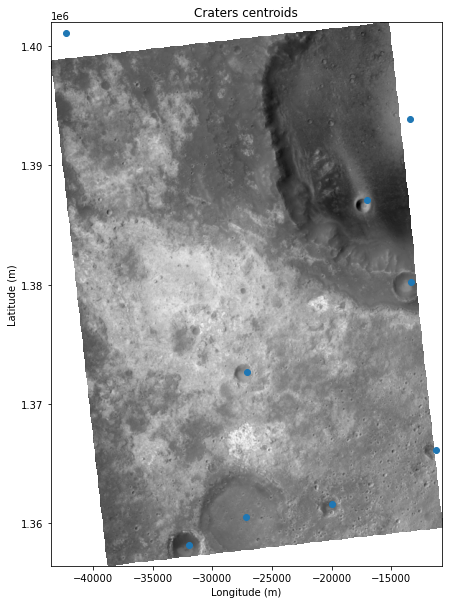

In [97]:
fig, ax = pyplot.subplots(figsize=(10,10))

rplot.show(ctx_src, ax=ax, cmap='gray');
craters_select.plot(ax=ax)

ax.set_xlabel('Longitude (m)')
ax.set_ylabel('Latitude (m)')
ax.set_title('Craters centroids');

In [95]:
craters_select['buffer'] = craters_select.apply(lambda r:r.geometry.buffer(r.RADIUS), axis=1)

craters_select

/opt/miniconda3/envs/npt/lib/python3.10/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,CRATER_ID,RADIUS,X,Y,TYPE,STATUS,LRD_MORPH,ORIGIN,ADDING,geometry,buffer
154389,11-008387,765.0,-17.313000,23.400999,1.0,Other,None,None,0.0,POINT (-17026.955 1387087.137),POLYGON ((-16261.9550386167 1387087.1374681853...
169650,11-007526,825.0,-17.205999,23.048000,1.0,Other,None,None,0.0,POINT (-11235.850 1366163.229),POLYGON ((-10410.849753784327 1366163.22851715...
172916,11-007296,840.0,-17.497999,23.158001,1.0,Other,None,None,0.0,POINT (-27140.234 1372683.505),POLYGON ((-26300.233955313168 1372683.50451941...
205174,11-005350,1040.0,-17.365999,22.972000,1.0,Other,None,None,0.0,POINT (-19974.014 1361658.352),POLYGON ((-18934.014267012863 1361658.35150539...
226455,11-004063,1265.0,-17.245001,23.285000,1.0,Other,None,None,0.0,POINT (-13339.513 1380211.332),POLYGON ((-12074.512529912254 1380211.33183018...
240704,11-003247,1515.0,-17.778999,23.636999,1.0,Other,None,None,0.0,POINT (-42301.039 1401075.966),POLYGON ((-40786.038686179825 1401075.96608369...
245495,11-002964,1630.0,-17.586000,22.913000,1.0,Other,None,None,0.0,POINT (-31994.282 1358161.144),POLYGON ((-30364.28240446321 1358161.144351515...
309505,11-001230,3845.0,-17.497999,22.952999,3.0,Buried,None,None,0.0,POINT (-27181.596 1360532.073),POLYGON ((-23336.595885440223 1360532.07297774...
317716,11-000306,12670.0,-17.247999,23.516001,3.0,Buried,None,None,0.0,POINT (-13479.206 1393903.846),POLYGON ((-809.2058485021716 1393903.846232766...


/opt/miniconda3/envs/npt/lib/python3.10/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


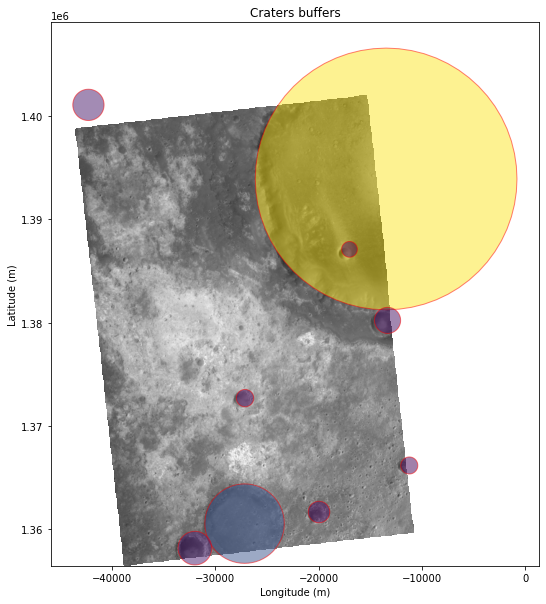

In [98]:
fig, ax = pyplot.subplots(figsize=(10,10))

rplot.show(ctx_src, ax=ax, cmap='gray');
ax = (
    craters_select.set_geometry('buffer')
    .sort_values('RADIUS', ascending=False)
    .plot(ax=ax, alpha=0.5, column=craters_buf.RADIUS, linewidth=1, edgecolor='red')
)

ax.set_xlabel('Longitude (m)')
ax.set_ylabel('Latitude (m)')
ax.set_title('Craters buffers');